## Harshal Dupare | 18MA20015 

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [161]:
import numpy as np
from time import time
import torch
import torch.nn as nn
import torch.functional as F
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms,datasets
from torch import nn, optim
from tqdm.notebook import tqdm

## ConvNN

2. Build a convolution neural network with given description (LeNet model). (only feed forward part, no backpropagation)
    * Convolution layer 1: 5*5, with 6 output channels
    * MaxPool1: 2*2, stride=2
    * Convolution layer 2: 5*5, with 16 output channels
    * MaxPool1: 2*2, stride=2
    * Linear Layer1: input (calculate yourself based on conv and pooling layer), output=120
    * Linear Layer2: input = 120, output=84
    * Linear Layer1: input=84, output=10
    * Use ReLU as activation function in each convolution and linear layer
    * Input: MNIST data (28*28)

In [178]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fcon1 = nn.Linear(256,120)
        self.fcon2 = nn.Linear(120,84)
        self.fcon3 = nn.Linear(84,10)
        
        self.relu = nn.ReLU()
        self.relu = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        
        x = self.conv1(x)      # [6,(28-5)/1+1,(28-5)/1+1] = [6,24,24]
        x = self.relu(x)
        x = self.maxpool1(x)   # [6,(24-2)/2+1,(24-2)/2+1] = [6,12,12]
        
        x = self.conv2(x)      # [16,(12-5)/1+1,(12-5)/1+1] = [16,8,8]
        x = self.relu(x)
        x = self.maxpool1(x)   # [16,(8-2)/2+1,(8-2)/2+1] = [16,4,4]
        
        x = x.view(-1,16*4*4)
        x = self.fcon1(x)
        x = self.relu(x)
        x = self.fcon2(x)
        x = self.relu(x)
        x = self.fcon3(x)
        
        # probs
        x = self.softmax(x)
        return x

In [82]:
transform_data = transforms.Compose([transforms.Resize(28),transforms.ToTensor()])
batch_size = 256

train_data = datasets.MNIST(root='./data',train=True,download=True,transform = transform_data)
trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4)

test_data = datasets.MNIST(root='./data',train=False,download=False,transform = transform_data)
testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=4)

print(len(train_data))
print(len(test_data))

60000
10000


In [83]:
def get_test_results(Model,TestLoader,Criterion):
    tepoch_loss = 0.0
    tcorrect_count = 0
    tsample_count = 0
    ti = 0
    
    for (tX_i,ty_i) in TestLoader:
        if using_gpu:
            tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
        
        toutput=Model(tX_i)
        
        ty_i_pred = torch.argmax(toutput,dim=1)
        
        tloss = Criterion(toutput,ty_i)
        
        tepoch_loss+=tloss
        
        tcorrect_count +=torch.sum(ty_i==ty_i_pred)
        tsample_count+=len(ty_i)
        ti+=1

    return tepoch_loss.item()/(ti),tcorrect_count/tsample_count

In [186]:
class Pipeline:
  def __init__(self,Model):
    self.model = Model()

  def load_data(self,batch_size=256,image_size=28):
    self.batch_size = batch_size
    transform_data = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])

    try:
      train_data = datasets.MNIST(root='./data',train=True,download=False,transform = transform_data)
    except:
      train_data = datasets.MNIST(root='./data',train=True,download=True,transform = transform_data)
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4)

    test_data = datasets.MNIST(root='./data',train=False,download=False,transform = transform_data)
    testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=4)

    return trainloader,testloader

  def train(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
    # training the model

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in tqdm(range(N_epoch)):
        epoch_loss = 0.0
        correct_count = 0
        sample_count = 0
        Optimizer.zero_grad()
        i = 0
        
        # on Traning Data
        for (X_i,y_i) in Trainloader:
            if using_gpu:
                X_i,y_i=X_i.cuda(),y_i.cuda()
            
            output=self.model(X_i)
            
            y_i_pred = torch.argmax(output,dim=1)
            
            loss = Criterion(output,y_i)
            
            epoch_loss+=loss
            
            correct_count +=torch.sum(y_i==y_i_pred)
            sample_count+=len(y_i)
            i+=1

        tepoch_loss = 0.0
        tcorrect_count = 0
        tsample_count = 0
        ti = 0
        
        # on Testing Data
        for (tX_i,ty_i) in Testloader:
            if using_gpu:
                tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
            
            toutput=self.model(tX_i)
            
            ty_i_pred = torch.argmax(toutput,dim=1)
            
            tloss = Criterion(toutput,ty_i)
            
            tepoch_loss+=tloss
            
            tcorrect_count +=torch.sum(ty_i==ty_i_pred)
            tsample_count+=len(ty_i)
            ti+=1

        epoch_loss=epoch_loss/(i)
        tepoch_loss=tepoch_loss/(ti)
        
        epoch_loss.backward()
        
        Optimizer.step()
        
        
        train_loss.append(epoch_loss.item())
        train_acc.append(100*correct_count.item()/sample_count)
        test_loss.append(tepoch_loss.item())
        test_acc.append(100*tcorrect_count.item()/tsample_count)
        if print_epoch_details:
          print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
    
    fig = plt.figure(figsize=[20,8]) 
    plt.subplot(121)
    plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
    plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(122)
    plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
    plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
    plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')

  def train_mini_batch(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
      # training the model

      train_loss = []
      train_acc = []
      mtrain_loss = []
      mtrain_acc = []
      test_loss = []
      test_acc = []
      for epoch in tqdm(range(N_epoch)):
          epoch_loss = 0.0
          correct_count = 0
          sample_count = 0
          i = 0
          
          # on Traning Data
          for (X_i,y_i) in Trainloader:
              if using_gpu:
                  X_i,y_i=X_i.cuda(),y_i.cuda()

              output=self.model(X_i)
              
              y_i_pred = torch.argmax(output,dim=1)
              
              loss = Criterion(output,y_i)
              mtrain_loss.append(loss.item())

              Optimizer.zero_grad()
              loss.backward()
              Optimizer.step()
              
              epoch_loss+=loss
              
              correct_count +=torch.sum(y_i==y_i_pred)
              sample_count+=len(y_i)
              mtrain_loss.append(loss.item())
              mtrain_acc.append(float(torch.sum(y_i==y_i_pred)/len(y_i))*100)

              i+=1

          tepoch_loss = 0.0
          tcorrect_count = 0
          tsample_count = 0
          ti = 0
          
          # on Testing Data
          for (tX_i,ty_i) in Testloader:
              if using_gpu:
                  tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
              
              toutput=self.model(tX_i)
              
              ty_i_pred = torch.argmax(toutput,dim=1)
              
              tloss = Criterion(toutput,ty_i)
              
              tepoch_loss+=tloss
              
              tcorrect_count +=torch.sum(ty_i==ty_i_pred)
              tsample_count+=len(ty_i)
              ti+=1

          epoch_loss=epoch_loss/(i)
          tepoch_loss=tepoch_loss/(ti)
          
          train_loss.append(epoch_loss.item())
          train_acc.append(100*correct_count.item()/sample_count)
          test_loss.append(tepoch_loss.item())
          test_acc.append(100*tcorrect_count.item()/tsample_count)
          if print_epoch_details:
            print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
      
      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
      plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.subplot(122)
      plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
      plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      print(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}")
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')
      plt.show()

      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(len(mtrain_loss)),mtrain_loss,'g-',label='Mini Batch Training Loss')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Loss')
      plt.legend(loc='upper right')
      plt.subplot(122)
      plt.plot(range(len(mtrain_acc)),mtrain_acc,'g-',label='Mini Batch Training Accuracy')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Accuracy')
      plt.legend(loc='upper right')
      plt.show()


Training using GPU: True


Epoch 1/50 : Training loss: 2.3026 | Training Accuracy: 9.94 | Testing loss: 2.3024 | Testing Accuracy: 9.67 
Epoch 2/50 : Training loss: 2.3023 | Training Accuracy: 9.99 | Testing loss: 2.3021 | Testing Accuracy: 9.72 
Epoch 3/50 : Training loss: 2.3020 | Training Accuracy: 10.05 | Testing loss: 2.3018 | Testing Accuracy: 9.79 
Epoch 4/50 : Training loss: 2.3016 | Training Accuracy: 10.20 | Testing loss: 2.3016 | Testing Accuracy: 10.00 
Epoch 5/50 : Training loss: 2.3013 | Training Accuracy: 10.58 | Testing loss: 2.3012 | Testing Accuracy: 10.52 
Epoch 6/50 : Training loss: 2.3010 | Training Accuracy: 11.38 | Testing loss: 2.3007 | Testing Accuracy: 11.71 
Epoch 7/50 : Training loss: 2.3006 | Training Accuracy: 13.03 | Testing loss: 2.3004 | Testing Accuracy: 13.68 
Epoch 8/50 : Training loss: 2.3001 | Training Accuracy: 14.94 | Testing loss: 2.2999 | Testing Accuracy: 15.63 
Epoch 9/50 : Training loss: 2.2996 | Training Accuracy: 16.79 | Testing loss: 2.2994 | Testing Accuracy: 17.5

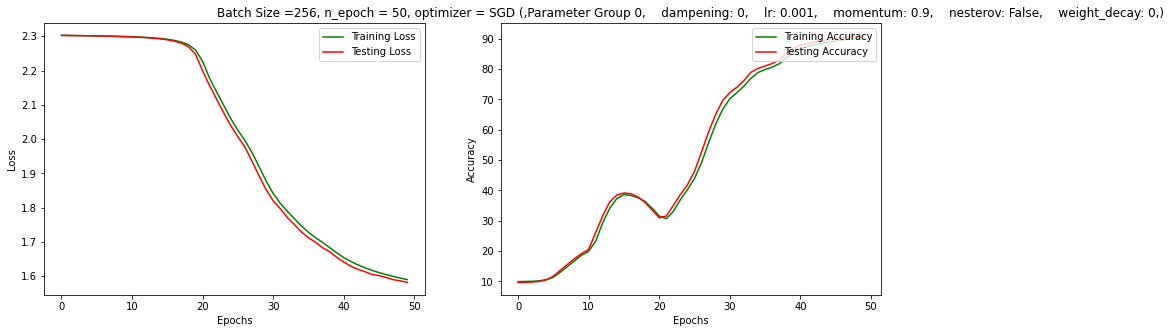

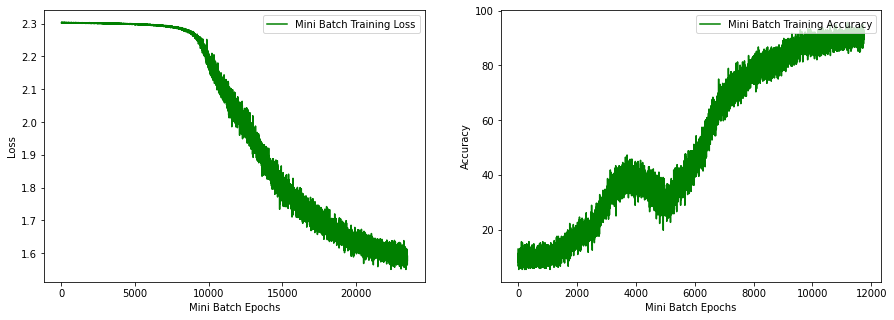

In [183]:
batch_size = 256
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

## Problem in using SGD so we can either increase the number of epoch by 100 or 1000 times OR change to mini batch OR use Adam

Refer: https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing

In [ ]:
# using SGD with mini batch

LR_list = [0.5,0.2,0.1,0.05,0.025] # learning rate list
BS_list = [32,64,128,256,1024] # batch size list

for batch_size in tqdm(BS_list):
  for learning_rate in tqdm(LR_list):
    momentum = 0.0

    criterion = nn.CrossEntropyLoss()
    pl = Pipeline(LeNet)

    trainloader,testloader = pl.load_data(batch_size)

    using_gpu = torch.cuda.is_available()
    if using_gpu:
        pl.model = pl.model.cuda()
        criterion = criterion.cuda()
    print("Training using GPU:",using_gpu)

    optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
    # optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)
    print(f"Batch Size : {batch_size}, Learning Rate : {learning_rate}")
    n_epoch = 50
    pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch,False)

Training using GPU: True
Batch Size : 32, Learning Rate : 0.5


# 6.B Observations

* x

# Varying Learning rate along with epoch

In [93]:
# training the model using ADAM

model = LeNet()
n_epoch = 50
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
momentum = 0
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,)
using_gpu = torch.cuda.is_available()

if using_gpu:
    model = model.cuda()
    criterion = criterion.cuda()
print("using GPU:",using_gpu)

using GPU: True


In [ ]:
n_epoch = 5
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
momentum = 0
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)
pl = Pipeline(FFNN)
pl.train(trainloader,testloader,criterion,optimizer,n_epoch)

In [ ]:
# training the model

train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in tqdm(range(n_epoch)):
    epoch_loss = 0.0
    correct_count = 0
    sample_count = 0
    optimizer.zero_grad()
    i = 0
    
    # on Traning Data
    for (X_i,y_i) in trainloader:
        if using_gpu:
            X_i,y_i=X_i.cuda(),y_i.cuda()
        
        output=model(X_i)
        
        y_i_pred = torch.argmax(output,dim=1)
        
        loss = criterion(output,y_i)
        
        epoch_loss+=loss
        
        correct_count +=torch.sum(y_i==y_i_pred)
        sample_count+=len(y_i)
        i+=1

    tepoch_loss = 0.0
    tcorrect_count = 0
    tsample_count = 0
    ti = 0
    
    # on Testing Data
    for (tX_i,ty_i) in testloader:
        if using_gpu:
            tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
        
        toutput=model(tX_i)
        
        ty_i_pred = torch.argmax(toutput,dim=1)
        
        tloss = criterion(toutput,ty_i)
        
        tepoch_loss+=tloss
        
        tcorrect_count +=torch.sum(ty_i==ty_i_pred)
        tsample_count+=len(ty_i)
        ti+=1

    epoch_loss=epoch_loss/(i)
    tepoch_loss=tepoch_loss/(ti)
    
    epoch_loss.backward()
    
    optimizer.step()
    
    
    train_loss.append(epoch_loss.item())
    train_acc.append(100*correct_count.item()/sample_count)
    test_loss.append(tepoch_loss.item())
    test_acc.append(100*tcorrect_count.item()/tsample_count)

    print(f'Epoch {epoch+1:.0f}/{n_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')

Text(0, 0.5, 'Accuracy')

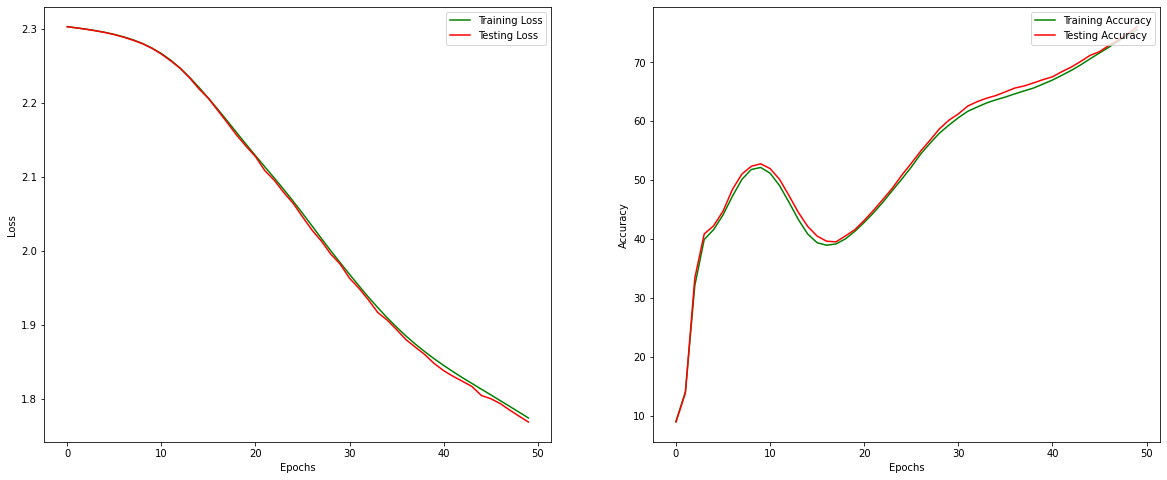

In [90]:
fig = plt.figure(figsize=[20,8]) 
plt.subplot(121)
plt.plot(range(n_epoch),train_loss,'g-',label='Training Loss') 
plt.plot(range(n_epoch),test_loss,'r-',label='Testing Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(range(n_epoch),train_acc,'g-',label='Training Accuracy') 
plt.plot(range(n_epoch),test_acc,'r-',label='Testing Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
# results on test set

# Batch Gradient Descent

train_loss = []
train_acc = []
for epoch in tqdm(range(n_epoch)):
    epoch_loss = 0.0
    correct_count = 0
    sample_count = 0
    optimizer.zero_grad()
    i = 0
    
    for (X_i,y_i) in trainloader:
        if using_gpu:
            X_i,y_i=X_i.cuda(),y_i.cuda()
        
        output=model(X_i)
        
        y_i_pred = torch.argmax(output,dim=1)
        
        loss = criterion(output,y_i)
        
        epoch_loss+=loss
        
        correct_count +=torch.sum(y_i==y_i_pred)
        sample_count+=len(y_i)
        i+=1
        
    epoch_loss=epoch_loss/(i)
    
    epoch_loss.backward()
    
    optimizer.step()
    
    train_loss.append(epoch_loss.item())
    train_acc.append(correct_count.item()/sample_count)
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,n_epoch,epoch_loss,(correct_count.item()/sample_count)*100))

In [26]:
# training the model using ADAM

model1 = LeNet()
n_epoch = 50
criterion = nn.CrossEntropyLoss()
learning_rate = 9e-3
optimizer = optim.Adam(model1.parameters(),lr=learning_rate)
using_gpu = torch.cuda.is_available()

if using_gpu:
    model1 = model1.cuda()
    criterion = criterion.cuda()

In [27]:
# Batch Gradient Descent

train_loss = []
train_acc = []
for epoch in tqdm(range(n_epoch)):
    epoch_loss = 0.0
    correct_count = 0
    sample_count = 0
    optimizer.zero_grad()
    i = 0
    
    for (X_i,y_i) in trainloader:
        if using_gpu:
            X_i,y_i=X_i.cuda(),y_i.cuda()
        
        output=model(X_i)
        
        y_i_pred = torch.argmax(output,dim=1)
        
        loss = criterion(output,y_i)
        
        epoch_loss+=loss
        
        correct_count +=torch.sum(y_i==y_i_pred)
        sample_count+=len(y_i)
        i+=1
        
    epoch_loss=epoch_loss/(i)
    
    epoch_loss.backward()
    
    optimizer.step()
    
    train_loss.append(epoch_loss.item())
    train_acc.append(correct_count.item()/sample_count)
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,n_epoch,epoch_loss,(correct_count.item()/sample_count)*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Epoch 1/50 : Training loss: 1.8909 | Training Accuracy: 56.9633
Epoch 2/50 : Training loss: 2.3305 | Training Accuracy: 13.0700


KeyboardInterrupt: ignored